In [1]:
import numpy as np
import os
import pandas as pd
import random
from collections import defaultdict
import gym
import gym_minigrid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class SARSA:
    def __init__(self, actions, agent_indicator=10, epsilon_start=0.99, epsilon_end=0.3, epsilon_decay=0.999):
        self.actions = actions
        self.agent_indicator = agent_indicator
        self.alpha = 0.01
        self.gamma = 0.9
        self.epsilon = epsilon_start  # 초기 epsilon 값
        self.epsilon_end = epsilon_end  # 최소 epsilon 값
        self.epsilon_decay = epsilon_decay  # epsilon 감소율
        self.q_values = defaultdict(lambda: [0.0] * actions)
        
    def _convert_state(self, s):
        return np.where(s == self.agent_indicator)[0][0]
        
    def update(self, state, action, reward, next_state, next_action):
        state = self._convert_state(state)
        next_state = self._convert_state(next_state)
        
        q_value = self.q_values[state][action]
        
        ################ Write Code #####################
        next_q_value = self.q_values[next_state][next_action]
        
        td_error = reward + self.gamma * next_q_value - q_value
        self.q_values[state][action] = q_value + self.alpha * td_error
        #################################################
    
    def act(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.actions)
        else:
            state = self._convert_state(state)
            q_values = self.q_values[state]
            action = np.argmax(q_values)
        return action
    
    def decay_epsilon(self):
        # epsilon이 최소값까지 감소하도록 업데이트
        if self.epsilon > self.epsilon_end:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_end


In [3]:
from utils import gen_wrapped_env, show_video

In [4]:
from gym.wrappers import TimeLimit

env = gen_wrapped_env('MiniGrid-LavaGapS5-v0')

env = TimeLimit(env, max_episode_steps=1000)

obs = env.reset()

agent_position = obs[0]

agent = SARSA(3, agent_position)

## For Sarsa
+ Sarsa update

In [5]:
rewards = []
for ep in range(50000):
    done = False
    obs = env.reset()
    action = agent.act(obs)
    
    ep_rewards = 0
    while not done:
        next_obs, reward, done, info = env.step(action)

        next_action = agent.act(next_obs)

        agent.update(obs, action, reward, next_obs, next_action)
        
        ep_rewards += reward
        obs = next_obs
        action = next_action
    rewards.append(ep_rewards)
    
    # epsilon 감소
    agent.decay_epsilon()
    
    if (ep+1) % 20 == 0:
        print("episode: {}, rewards: {}, epsilon: {:.4f}".format(ep+1, ep_rewards, agent.epsilon))
env.close()

NameError: name 'rewards' is not defined

In [ ]:
{s:np.round(q, 5).tolist() for s, q in agent.q_values.items()}

{0: [0.08816, 0.08824, 0.09969],
 9: [0.12589, 0.12601, 0.15814],
 3: [0.11588, 0.11566, 0.13564],
 12: [0.06802, 0.07725, 0.42282],
 21: [0.50565, 0.50969, 0.58009],
 18: [0.15027, 0.15068, 0.16089],
 15: [0.38026, 0.37666, 0.5405],
 6: [0.13234, 0.13144, 0.15898],
 24: [0.0, 0.0, 0.0]}

In [ ]:
show_video()

In [ ]:
os.makedirs('./logs', exist_ok=True)
pd.Series(rewards).to_csv('./logs/rewards_sarsa.csv')

In [ ]:
sarsa_logs = pd.read_csv('./logs/rewards_sarsa.csv', index_col=False).iloc[:, 1]
q_logs = pd.read_csv('./logs/rewards_qlearning.csv', index_col=False).iloc[:, 1]

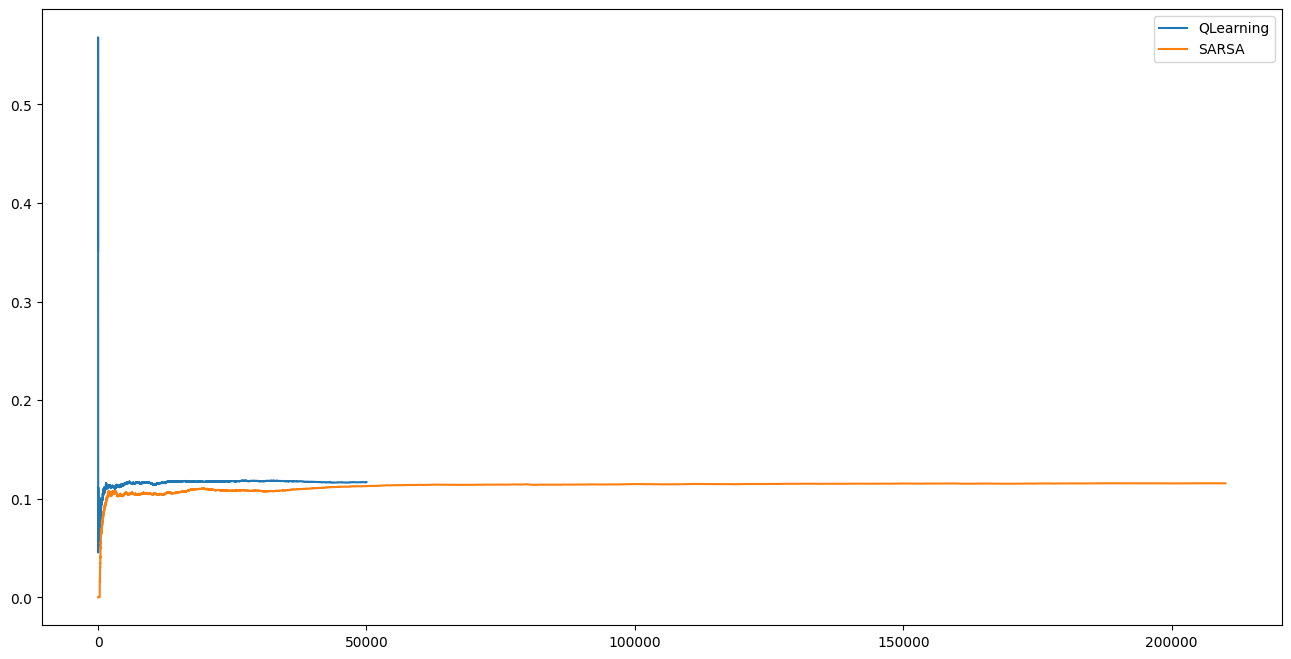

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(q_logs.cumsum() / (pd.Series(np.arange(q_logs.shape[0]))+1), label="QLearning")
plt.plot(sarsa_logs.cumsum() / (pd.Series(np.arange(sarsa_logs.shape[0]))+1), label="SARSA")
plt.legend()